## Cycling Potential
### How to calculate a trip cycling potential 

This notebook aims to define parameters to calculate a trip cycling potential, considering the current characteristics of São Paulo bike trips.

It is necessary to identify all attributes, calculate the attribute specific value and to develop a method to aggregate all attributes

In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route

from math import floor
import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000
the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

total_trips = sum(od_routes_sp['FE_VIA'])
eps = 1e-5

# return a list [value_10, value_20, ..., value_100] 
# where value_x is the value whose x% of the data is less than it  
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - eps:
            stats.append(i[value])
    return stats

od_routes_FE_VIA = []
for i, r in od_routes_sp.iterrows():
    for w in range(round(r['FE_VIA'])):
        od_routes_FE_VIA.append(r)
        
od_routes_FE_VIA = pd.DataFrame(data = od_routes_FE_VIA, columns = od_routes_sp.columns)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Distance

The first attribute we consider is the trip distance.

The longer a trip is, the less cyclable it is. The distance is calculated using the routes calculated by the GraphHopper API. 

However, very short trips are hard to migrate to cycling because they are most likely made on foot.

The current Sao Paulo bike trips distance distribution is represented in the following graphs.

distance  10%:	 994
distance  20%:	 1343
distance  30%:	 1759
distance  40%:	 2310
distance  50%:	 2893
distance  60%:	 3703
distance  70%:	 4545
distance  80%:	 6613
distance  90%:	 10372
distance  100%:	 48888


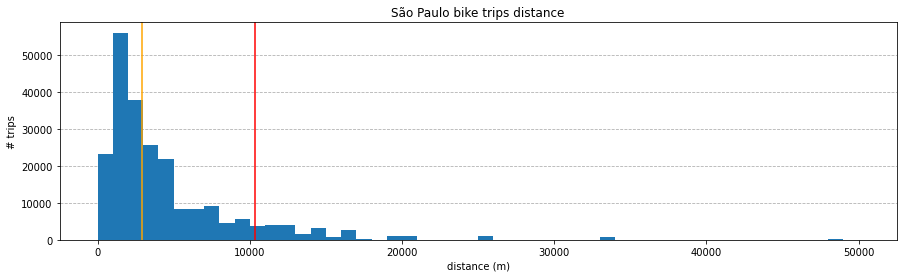

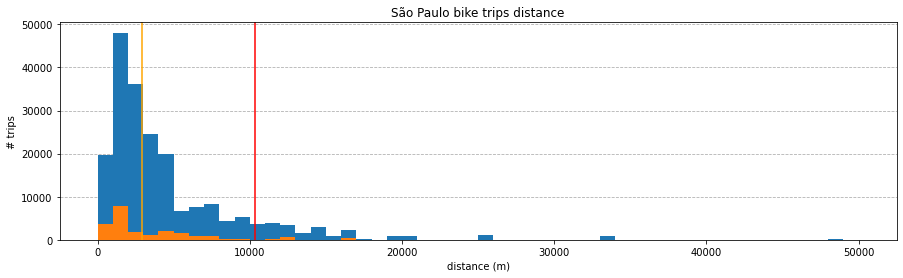

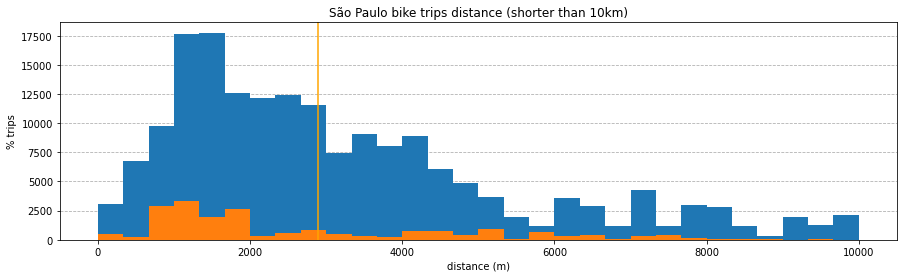

In [2]:
od_routes_sp = od_routes_sp.sort_values('length')

s = stats(od_routes_sp, 'length')
for i in range(10):
    print('distance  ' + str(i + 1) + '0%:\t', round(s[i]))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')

plt.savefig('./images/bike_trips_distance')
plt.show()    

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0, 50000))
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_distance_gender')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000))
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000))
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.savefig('./images/bike_trips_shorter_10km')
plt.show()

In [3]:
#od_routes_sp['length_scaled'] = od_routes_sp['length'] / max(od_routes_sp['length'])
#distrib_scaled = dist.best_fit_distribution(od_routes_sp['length_scaled'], bins = 100)

#distrib = dist.best_fit_distribution(od_routes_sp['length'], bins = 100)

#distrib_m = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 1]['length'], bins = 100)
#distrib_f = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 2]['length'], bins = 100)

#('invweibull', (1.9624908421440037, -1358.5912359607478, 3558.697966253873))
#('johnsonsu',(-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))

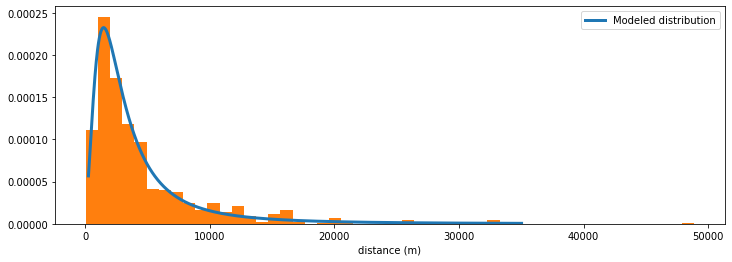

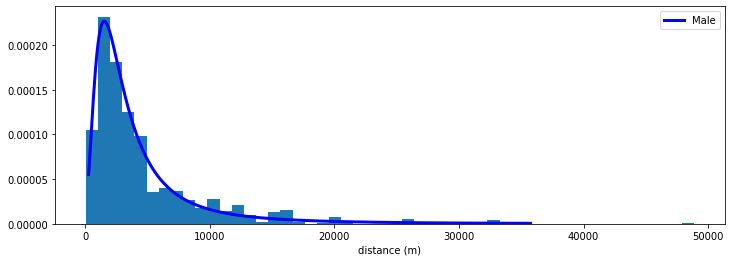

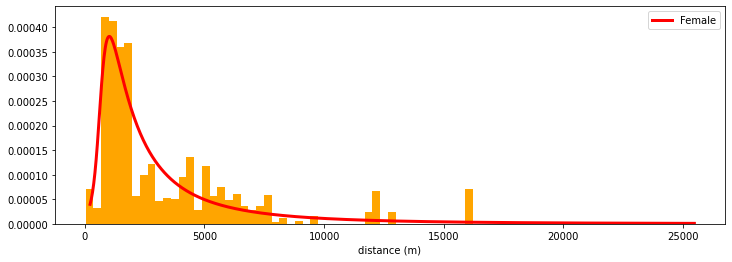

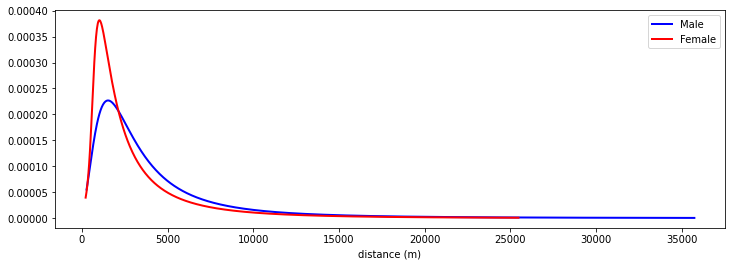

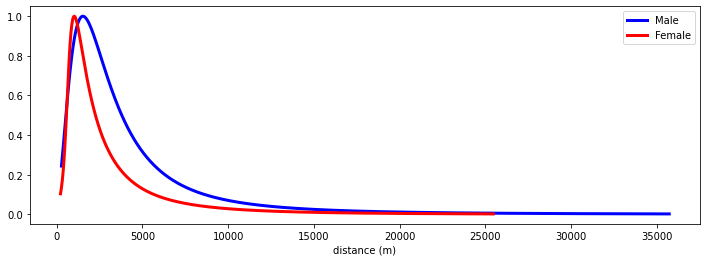

In [4]:
import scipy.stats as st
#display(distrib_m)
#display(distrib_f)

#display(distrib_weighted)
#'invweibull', (1.9570057637337088, -1328.576035175634, 3464.328480602161))

distance_pdf = dist.make_pdf(st.invweibull, (1.9570057637337088, -1328.576035175634, 3464.328480602161))
plt.figure(figsize=(12,4))
ax = distance_pdf.plot(lw=3, label='Modeled distribution', legend=True)
plt.hist(bins=50, x=od_routes_sp['length'], weights = od_routes_sp['FE_VIA'], density=True)
plt.xlabel('distance (m)')
plt.savefig('./images/bike_trips_distance_modeled_distribution')
plt.show()

#display(distrib_scaled)
#'exponweib', (27.275206430379725, 0.40869845919320125, -0.0057640780042170015, 0.002630359396941097))

#distance_pdf = dist.make_pdf(st.exponweib, (27.275206430379725, 0.40869845919320125, -0.0057640780042170015, 0.002630359396941097))
#plt.figure(figsize=(12,8))
#ax = distance_pdf.plot(lw=3, label='Modeled distribuition', legend=True)
#plt.hist(bins=50, x=od_routes_sp['length_scaled'], weights = od_routes_sp['FE_VIA'], density=True)
#plt.show()

#('invweibull', (1.9624908421440037, -1358.5912359607478, 3558.697966253873))

#('johnsonsu',(-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
distance_pdf_m = dist.make_pdf(st.invweibull,  (1.9624908421440037, -1358.5912359607478, 3558.697966253873))
distance_pdf_f = dist.make_pdf(st.johnsonsu,  (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))

plt.figure(figsize=(12,4))
ax = distance_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], density=True)
plt.xlabel('distance (m)')
plt.savefig('./images/bike_trips_distance_modeled_distribution_male')
plt.show()

plt.figure(figsize=(12,4))
ax = distance_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], density=True, color='orange')
plt.xlabel('distance (m)')
plt.savefig('./images/bike_trips_distance_modeled_distribution_female')
plt.show()

plt.figure(figsize=(12,4))
ax = distance_pdf_m.plot(lw=2, label='Male', legend=True, color='blue')
ax = distance_pdf_f.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('distance (m)')
plt.savefig('./images/bike_trips_distance_modeled_distribution_male_female')
plt.show()

max_m = max(d for d in distance_pdf_m)
max_f = max(d for d in distance_pdf_f)
distance_m_scaled = distance_pdf_m / max_m
distance_f_scaled = distance_pdf_f / max_f

plt.figure(figsize=(12,4))
ax = distance_m_scaled.plot(lw=3, label='Male', legend=True, color='blue')
ax = distance_f_scaled.plot(lw=3, label='Female', legend=True, color='red')
plt.savefig('./images/bike_trips_distance_modeled_distribution_scaled')
plt.xlabel('distance (m)')
plt.show()

# Slope

In [5]:
# calculating statistics
stats_slope = []
for _, r in od_routes_sp.iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['SEXO'] = r['SEXO']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = floor(stretchs[0][1])
    for stch in stretchs:
        s['meters_slope_' + str(floor(stch[1]))] += stch[0].length * 100000
        if current_slope == floor(stch[1]):
            meters_in_slope += stch[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = stch[0].length * 100000
            current_slope = round(stch[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'sexo', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

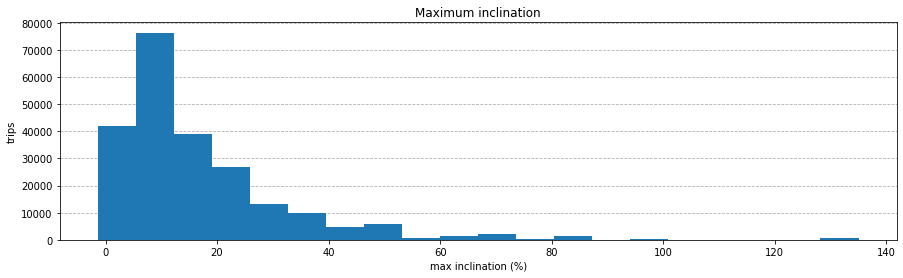

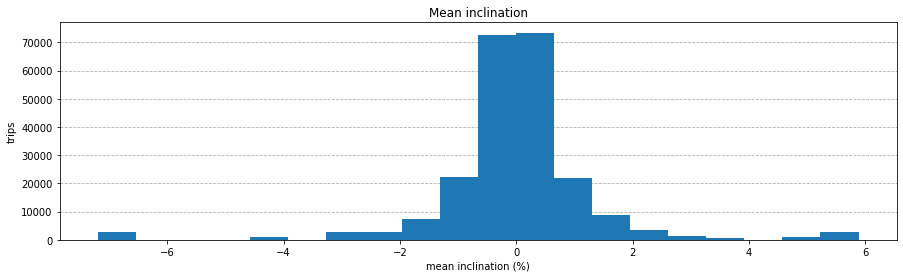

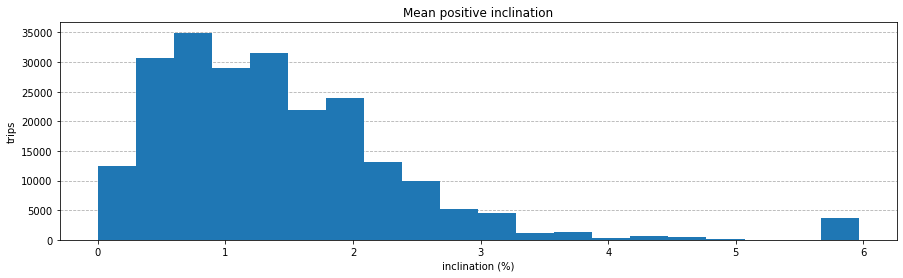

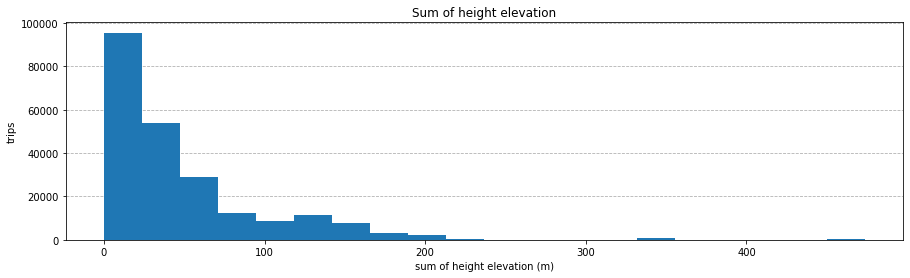

In [6]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['max'], weights = df_stats['fe_via'])
plt.title('Maximum inclination')
plt.xlabel('max inclination (%)')
plt.ylabel('trips')
plt.savefig('./images/bike_trips_max_inclination')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean'], weights = df_stats['fe_via'])
plt.title('Mean inclination')
plt.xlabel('mean inclination (%)')
plt.ylabel('trips')
plt.savefig('./images/bike_trips_mean_inclination')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean_pos'], weights = df_stats['fe_via'])
plt.title('Mean positive inclination')
plt.xlabel('inclination (%)')
plt.ylabel('trips')
plt.savefig('./images/bike_trips_mean_positive_inclination')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['std_height'], weights = df_stats['fe_via'])
plt.title('Height Standard Deviation')
plt.xlabel('height standard deviation (m)')
plt.ylabel('trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['sum_elevs'], weights = df_stats['fe_via'])
plt.title('Sum of height elevation')
plt.xlabel('sum of height elevation (m)')
plt.ylabel('trips')
plt.savefig('./images/bike_trips_height_elevaton')
plt.show()

### Sum of distances in each level

In [7]:
meters_slope_mean = []
meters_slope = []
meters_slope_m = []
meters_slope_f = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.loc[df_stats['sexo'] == 1].iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_m.append(meters_slope_i)

for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.loc[df_stats['sexo'] == 2].iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_f.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

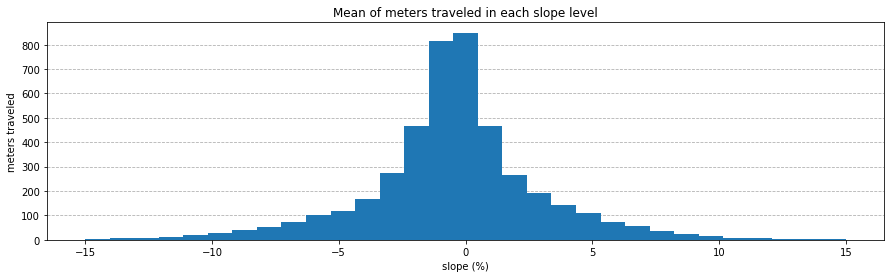

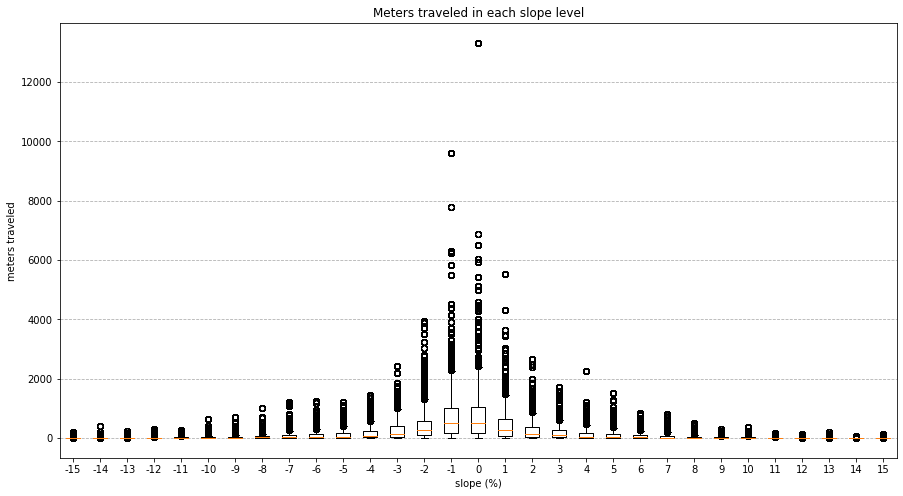

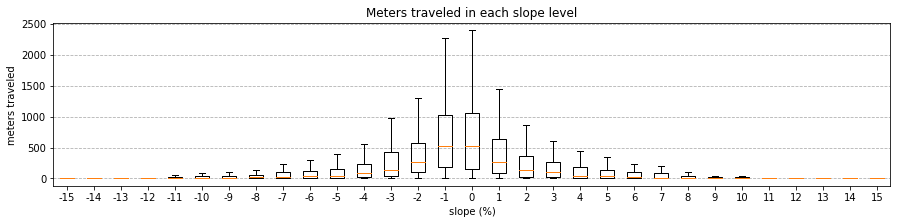

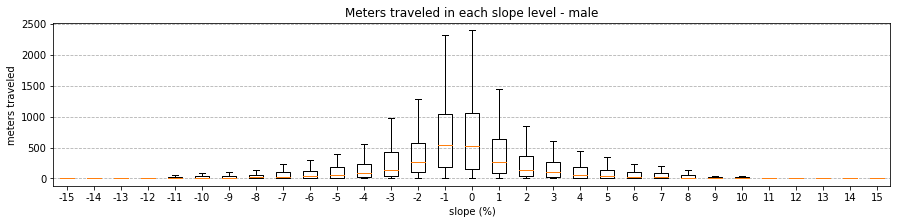

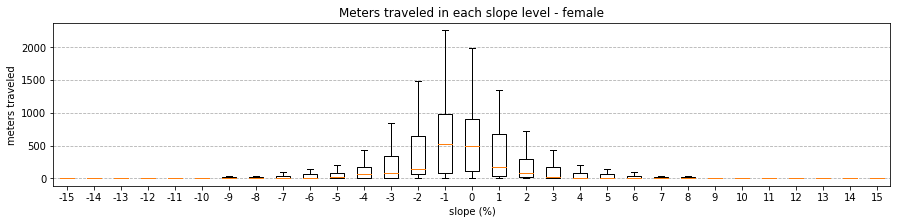

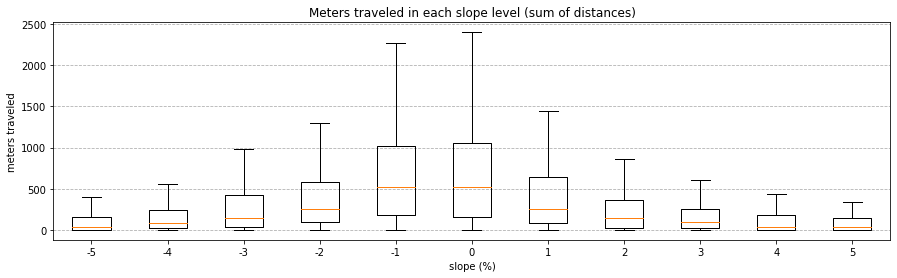

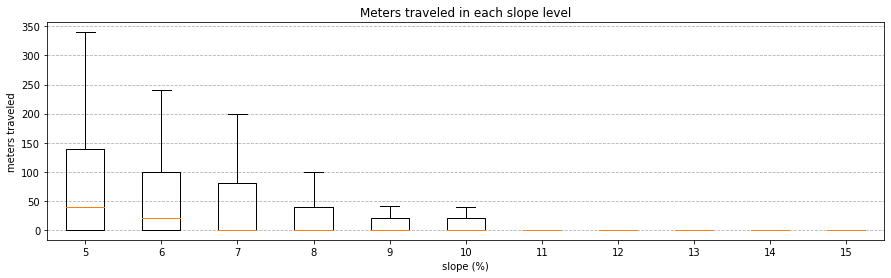

In [8]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_mean')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_boxplot_outliers')
plt.show()


plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_boxplot')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_m, positions=range(-15,16), showfliers=False)
plt.title('Meters traveled in each slope level - male')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_boxplot_male')
plt.show()


plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_f, positions=range(-15,16), showfliers=False)
plt.title('Meters traveled in each slope level - female')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_boxplot_female')
plt.show()


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (sum of distances)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

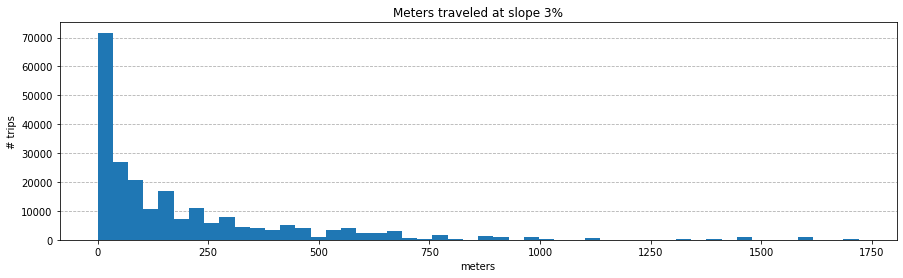

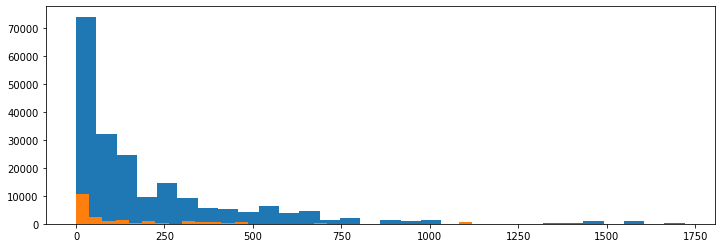

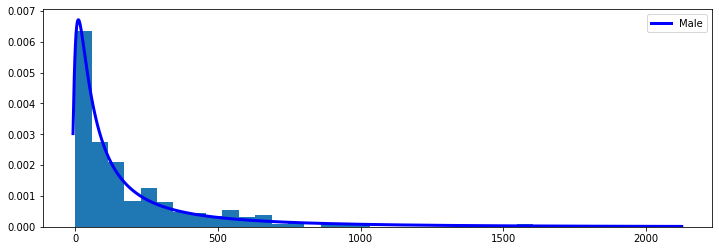

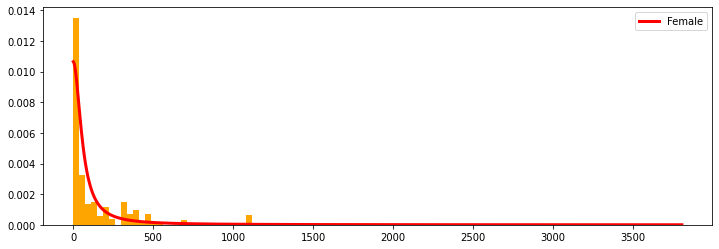

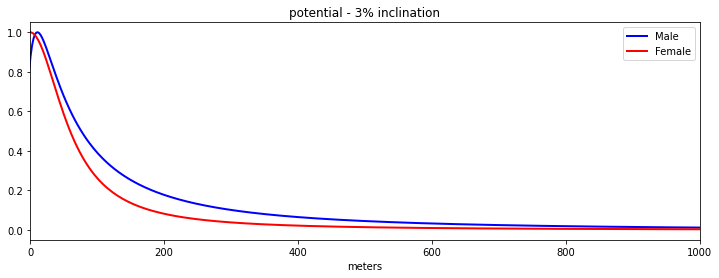

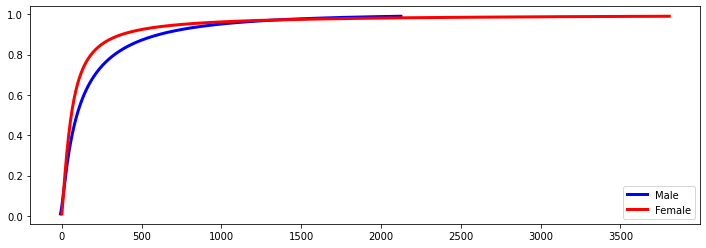

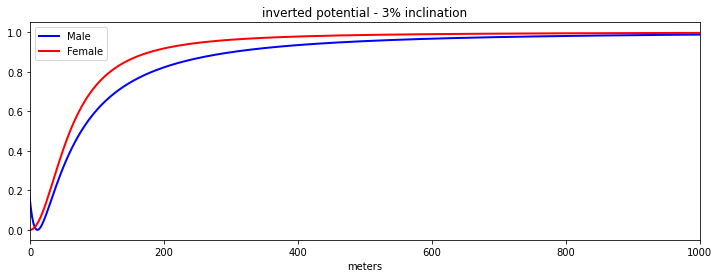

In [9]:

s = stats(df_stats, 'meters_slope_3', 'fe_via')

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=df_stats['meters_slope_3'], weights=df_stats['fe_via'])
plt.title('Meters traveled at slope 3%')
plt.xlabel('meters')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins=30, x=df_stats.loc[df_stats['sexo'] == 1]['meters_slope_3'], 
         weights=df_stats.loc[df_stats['sexo'] == 1]['fe_via'])
plt.hist(bins=30, x=df_stats.loc[df_stats['sexo'] == 2]['meters_slope_3'], 
         weights=df_stats.loc[df_stats['sexo'] == 2]['fe_via'])
plt.show()

pdf_m = dist.make_pdf(st.invgauss, (2.688687820077516, -21.13444964695273, 97.67944984207021))
plt.figure(figsize=(12,4))
ax = pdf_m.plot(lw=3, label='Male', legend=True, color = 'blue')
plt.hist(bins=30, x=df_stats.loc[df_stats['sexo'] == 1]['meters_slope_3'], 
         weights=df_stats.loc[df_stats['sexo'] == 1]['fe_via'], density=True)
plt.show()

pdf_f = dist.make_pdf(st.halfcauchy, (-1.6974581783015064e-09, 59.79317588661688))
plt.figure(figsize=(12,4))
ax = pdf_f.plot(lw=3, label='Female', legend=True, color = 'red')
plt.hist(bins=30, x=df_stats.loc[df_stats['sexo'] == 2]['meters_slope_3'], 
         weights=df_stats.loc[df_stats['sexo'] == 2]['fe_via'], color='orange', density=True)
plt.show()

max_m = max(d for d in pdf_m)
max_f = max(d for d in pdf_f)
slope3_m_scaled = pdf_m / max_m
slope3_f_scaled = pdf_f / max_f

plt.figure(figsize=(12,4))
ax = slope3_m_scaled.plot(lw=2, label='Male', legend=True, color='blue', xlim=(0, 1000))
ax = slope3_f_scaled.plot(lw=2, label='Female', legend=True, color='red', xlim=(0, 1000))
plt.xlabel('meters')
plt.title('potential - 3% inclination')
plt.show()

pdf_m_cdf = dist.make_cdf(st.invgauss, (2.688687820077516, -21.13444964695273, 97.67944984207021))
pdf_f_cdf = dist.make_cdf(st.halfcauchy, (-1.6974581783015064e-09, 59.79317588661688))
plt.figure(figsize=(12,4))
ax = pdf_m_cdf.plot(lw=3, label='Male', legend=True, color = 'blue')
ax = pdf_f_cdf.plot(lw=3, label='Female', legend=True, color = 'red')
plt.show()

slope3_m_inverse = 1 - slope3_m_scaled
slope3_f_inverse = 1 - slope3_f_scaled

plt.figure(figsize=(12,4))
ax = slope3_m_inverse.plot(lw=2, label='Male', legend=True, color='blue', xlim=(0, 1000))
ax = slope3_f_inverse.plot(lw=2, label='Female', legend=True, color='red', xlim=(0, 1000))
plt.xlabel('meters')
plt.title('inverted potential - 3% inclination')
plt.show()


In [10]:
distribs_m = []
distribs_f = []
for slope in range(0, 16):
    df_stats_w = []
    for i, r in df_stats.iterrows():
        for w in range(round(r['fe_via'])):
            df_stats_w.append([r['meters_slope_' + str(slope)], r['sexo']])
    df_stats_w = pd.DataFrame(data = df_stats_w, columns = ['meters', 'sexo'])
   
    d_m = dist.best_fit_distribution(df_stats_w.loc[df_stats_w['sexo'] == 1]['meters'], bins = 30)
    d_f = dist.best_fit_distribution(df_stats_w.loc[df_stats_w['sexo'] == 2]['meters'], bins = 30)
    distribs_m.append(d_m)
    distribs_f.append(d_f)
    print(slope, d_m, d_f)
print(distribs_m, distribs_f)


for slope in range(0, 16):
    print("${}% - \n\t male:   {} \n\t female: {}".format(slope, distribs_m[slope], distribs_f[slope]))

#('invgauss', (2.688687820077516, -21.13444964695273, 97.67944984207021))
#('halfcauchy', (-1.6974581783015064e-09, 59.79317588661688))
distrbs_m_pdf = []
distrbs_f_pdf = []

distrbs_m_pdf.append(dist.make_pdf(st.halfgennorm, distribs_m[0][1]))
distrbs_m_pdf.append(dist.make_pdf(st.wald, distribs_m[1][1]))
distrbs_m_pdf.append(dist.make_pdf(st.invgauss, distribs_m[2][1]))
distrbs_m_pdf.append(dist.make_pdf(st.invgauss, distribs_m[3][1]))
distrbs_m_pdf.append(dist.make_pdf(st.invgauss, distribs_m[4][1]))
distrbs_m_pdf.append(dist.make_pdf(st.halfcauchy, distribs_m[5][1]))
distrbs_m_pdf.append(dist.make_pdf(st.beta, distribs_m[6][1]))
distrbs_m_pdf.append(dist.make_pdf(st.foldcauchy, distribs_m[7][1]))
distrbs_m_pdf.append(dist.make_pdf(st.foldcauchy, distribs_m[8][1]))
distrbs_m_pdf.append(dist.make_pdf(st.pearson3, distribs_m[9][1]))
distrbs_m_pdf.append(dist.make_pdf(st.wald, distribs_m[10][1]))
distrbs_m_pdf.append(dist.make_pdf(st.wald, distribs_m[11][1]))
distrbs_m_pdf.append(dist.make_pdf(st.wald, distribs_m[12][1]))
distrbs_m_pdf.append(dist.make_pdf(st.exponnorm, distribs_m[13][1]))
distrbs_m_pdf.append(dist.make_pdf(st.loglaplace, distribs_m[14][1]))
distrbs_m_pdf.append(dist.make_pdf(st.exponnorm, distribs_m[15][1]))

distrbs_f_pdf.append(dist.make_pdf(st.exponpow, distribs_f[0][1]))
distrbs_f_pdf.append(dist.make_pdf(st.gengamma, distribs_f[1][1]))
distrbs_f_pdf.append(dist.make_pdf(st.gengamma, distribs_f[2][1]))
distrbs_f_pdf.append(dist.make_pdf(st.halfcauchy, distribs_f[3][1]))
distrbs_f_pdf.append(dist.make_pdf(st.halfcauchy, distribs_f[4][1]))
distrbs_f_pdf.append(dist.make_pdf(st.gilbrat, distribs_f[5][1]))
distrbs_f_pdf.append(dist.make_pdf(st.gilbrat, distribs_f[6][1]))
distrbs_f_pdf.append(dist.make_pdf(st.pearson3, distribs_f[7][1]))
distrbs_f_pdf.append(dist.make_pdf(st.wald, distribs_f[8][1]))
distrbs_f_pdf.append(dist.make_pdf(st.wald, distribs_f[9][1]))
distrbs_f_pdf.append(dist.make_pdf(st.gilbrat, distribs_f[10][1]))
distrbs_f_pdf.append(dist.make_pdf(st.loglaplace, distribs_f[11][1]))
distrbs_f_pdf.append(dist.make_pdf(st.wald, distribs_f[12][1]))
distrbs_f_pdf.append(dist.make_pdf(st.lomax, distribs_f[13][1]))
distrbs_f_pdf.append(dist.make_pdf(st.wald, distribs_f[14][1]))
distrbs_f_pdf.append(dist.make_pdf(st.exponnorm, distribs_f[15][1]))

Trying 0/83 - alpha
Trying 1/83 - anglit
Trying 2/83 - arcsine
Trying 3/83 - beta
Trying 4/83 - betaprime
Trying 5/83 - bradford
Trying 6/83 - burr
Trying 7/83 - cauchy
Trying 8/83 - chi
Trying 9/83 - chi2
Trying 10/83 - cosine
Trying 11/83 - dgamma
Trying 12/83 - dweibull
Trying 13/83 - erlang
Trying 14/83 - expon
Trying 15/83 - exponnorm
Trying 16/83 - exponweib
Trying 17/83 - exponpow
Trying 18/83 - f
Trying 19/83 - fatiguelife
Trying 20/83 - fisk
Trying 21/83 - foldcauchy
Trying 22/83 - foldnorm
Trying 23/83 - genlogistic
Trying 24/83 - genpareto
Trying 25/83 - gennorm
Trying 26/83 - genexpon
Trying 27/83 - genextreme


KeyboardInterrupt: 

In [11]:
for i in range(1,10):
    max_m = max(d for d in distrbs_m_pdf[i])
    max_f = max(d for d in distrbs_f_pdf[i])
    
    slope_m_scaled = distrbs_m_pdf[i] / max_m
    slope_f_scaled = distrbs_f_pdf[i] / max_f
    
    slope_m_inverse = 1 - slope_m_scaled
    slope_f_inverse = 1 - slope_f_scaled

    plt.figure(figsize=(12,4))
    ax = slope_m_inverse.plot(lw=2, label='Male', legend=True, color='blue', xlim=(0, 1000))
    ax = slope_f_inverse.plot(lw=2, label='Female', legend=True, color='red', xlim=(0, 1000))
    plt.xlabel('meters')
    plt.title('"inverse" distribution - ' + str(i) + '%')
    plt.show()
    plt.figure(figsize=(12,4))
    ax = distrbs_m_pdf[i].plot(lw=2, label='Male', legend=True, color='blue', xlim=(0, 1000))
    ax = slope_f_inverse.plot(lw=2, label='Female', legend=True, color='red', xlim=(0, 1000))
    plt.xlabel('meters')
    plt.title('"inverse" distribution - ' + str(i) + '%')
    plt.show()

max_m = max(d for d in distrbs_m_pdf[11])
max_f = max(d for d in distrbs_f_pdf[11])
slope_m_scaled = distrbs_m_pdf[11] / max_m
slope_f_scaled = distrbs_f_pdf[11] / max_f

slope_m_inverse = 1 - slope_m_scaled
slope_f_inverse = 1 - slope_f_scaled

plt.figure(figsize=(12,4))
ax = slope_m_inverse.plot(lw=2, label='Male', legend=True, color='blue', xlim=(0, 100))
ax = slope_f_inverse.plot(lw=2, label='Female', legend=True, color='red', xlim=(0, 100))
plt.xlabel('meters')
plt.title('"inverse" distribution - +10%')
plt.show()


NameError: name 'distrbs_m_pdf' is not defined

In [ ]:
od_people = od_routes_sp.groupby('ID_PESS').max()


od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 100)
#print(distrib_weighted)
#'genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167)


#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 25)
#print(distrib_weighted)
#genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167))

# Age

In [ ]:
od_people = od_routes_sp.groupby('ID_PESS').max()


od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 100)
#distrib_m = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 5)
#distrib_f = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 2]['IDADE'], bins = 5)
#print(distrib_m)
#print(distrib_f)
# bins=100
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165))

#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728))

#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))

#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 25)
#print(distrib_weighted)
#genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167))

In [ ]:
import scipy.stats as st
#display(distrib_weighted)
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_age')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_age_groups')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'])
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_age_gender')
plt.show()

distance_pdf = dist.make_pdf(st.genextreme, (0.195561684562034, 27.800891741589794, 13.381742809374167))
plt.figure(figsize=(12,8))
ax = distance_pdf.plot(lw=3, label='Modeled distribuition', legend=True)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'], density=True)
plt.savefig('./images/bike_trips_age_modeled_distribution')
plt.show()

In [ ]:
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165)) fem 100 bins
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728)) fem 50 bins

# 20 bins
#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))
#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))
#('laplace', (29.0, 7.783973688144715))
#('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))


age_pdf_m = dist.make_pdf(st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
age_pdf_f = dist.make_pdf(st.dweibull, (0.7423596624388107, 28.999999999999993, 8.493736966849728))
plt.figure(figsize=(12,4))
plt.hist(bins = 5, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=True)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.laplace, (29.0, 7.783973688144715))
plt.figure(figsize=(12,4))
plt.hist(bins = 10, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.loggamma, (897.3569843061273, -2332.923603808461, 347.1732584129129))
plt.figure(figsize=(12,4))
plt.hist(bins = 5, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
ax = age_pdf_m.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_pdf_f.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

max_m = max(d for d in age_pdf_m)
max_f = max(d for d in age_pdf_f)
age_m_scaled = age_pdf_m / max_m
age_f_scaled = age_pdf_f / max_f

plt.figure(figsize=(12,4))
ax = age_m_scaled.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_f_scaled.plot(lw=2, label='Female', legend=True, color='red')
plt.savefig('./images/age_modeled_distribution_scaled')
plt.xlabel('age')
plt.show()
